# Exam Score Prediction

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## Dataset Selection and Loading



In [2]:
# Load your dataset
try:
    data = pd.read_csv('Exam_Score_Prediction.csv')
    print("✓ Dataset loaded successfully")
except FileNotFoundError:
    print("Error: Exam_Score_Prediction.csv not found. Please upload the file.")

# Dataset information
dataset_name = "Student Exam Score Prediction"
dataset_source = "https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset"
n_samples = data.shape[0]
n_features = data.shape[1] - 2 # Excluding target and student_id
problem_type = "regression"  # Predicting continuous exam score

# Problem statement
problem_statement = """
I am predicting students' final exam scores based on various factors like study hours, 
sleep quality, and class attendance. This is a regression problem. accurately predicting scores 
can help educators identify at-risk students early and provide necessary interventions.
"""

# Primary evaluation metric
primary_metric = "rmse" # Root Mean Squared Error

# Metric justification
metric_justification = """
I chose RMSE (Root Mean Squared Error) because it measures the average magnitude of the errors 
in the same units as the target variable (exam scores). Penalizing larger errors is important 
in this context to avoid significantly overestimating or underestimating a student's performance.
"""

print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Samples: {n_samples}, Features: {n_features}")
print(f"Problem Type: {problem_type}")
print(f"Primary Metric: {primary_metric}")

✓ Dataset loaded successfully
Dataset: Student Exam Score Prediction
Source: https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset
Samples: 20000, Features: 11
Problem Type: regression
Primary Metric: rmse


##  Data Preprocessing



In [3]:
# 1. Clean Data
# Drop irrelevant ID column
if 'student_id' in data.columns:
    data = data.drop('student_id', axis=1)

# Handle missing values (if any)
data = data.dropna()

# 2. Separate Features and Target
target_col = 'exam_score'
X_raw = data.drop(target_col, axis=1)
y_raw = data[target_col].values.reshape(-1, 1)

# 3. Encode Categorical Variables
# Identify categorical columns
categorical_cols = X_raw.select_dtypes(include=['object']).columns
numerical_cols = X_raw.select_dtypes(exclude=['object']).columns

# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X_raw, columns=categorical_cols, drop_first=True)

# Convert to numpy array
X = X_encoded.values
y = y_raw

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fill these for the template results
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]
train_test_ratio = 0.8

print(f"Train samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Split ratio: {train_test_ratio:.1%}")
print(f"Input features after encoding: {X_train.shape[1]}")

Train samples: 16000
Test samples: 4000
Split ratio: 80.0%
Input features after encoding: 23


## Baseline Model Implementation


In [4]:
class BaselineModel:
    """
    Baseline Linear Regression model using Gradient Descent
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.weights = np.zeros((n_features, 1))
        self.bias = 0
        
        # Gradient descent loop
        for i in range(self.n_iterations):
            # 1. Forward pass
            y_pred = np.dot(X, self.weights) + self.bias
            
            # 2. Compute loss (MSE)
            loss = np.mean((y - y_pred) ** 2)
            self.loss_history.append(loss)
            
            # 3. Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) # Derivative w.r.t weights
            db = (1 / n_samples) * np.sum(y_pred - y)        # Derivative w.r.t bias
            
            # 4. Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            if i % 100 == 0:
                print(f"Iteration {i}: Loss {loss:.4f}")
                
        return self
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias



In [5]:
# Train baseline model
print("Training baseline model...")
baseline_start_time = time.time()

# TODO: Initialize and train your baseline model
# We use the scaled training data and training labels
baseline_model = BaselineModel(learning_rate=0.01, n_iterations=1000)
baseline_model.fit(X_train_scaled, y_train)

# TODO: Make predictions
# We predict on the scaled test data
baseline_predictions = baseline_model.predict(X_test_scaled)

baseline_training_time = time.time() - baseline_start_time
print(f"✓ Baseline training completed in {baseline_training_time:.2f}s")
print(f"✓ Loss decreased from {baseline_model.loss_history[0]:.4f} to {baseline_model.loss_history[-1]:.4f}")
print("✓ Baseline trained")

Training baseline model...
Iteration 0: Loss 4269.1094
Iteration 100: Loss 659.8812
Iteration 200: Loss 174.8338
Iteration 300: Loss 108.3605
Iteration 400: Loss 98.6197
Iteration 500: Loss 96.8470
Iteration 600: Loss 96.3409
Iteration 700: Loss 96.1160
Iteration 800: Loss 95.9927
Iteration 900: Loss 95.9206
✓ Baseline training completed in 1.14s
✓ Loss decreased from 4269.1094 to 95.8779
✓ Baseline trained


##  Multi-Layer Perceptron Implementation



In [6]:
class MLP:
    """
    Multi-Layer Perceptron implemented from scratch
    """
    def __init__(self, architecture, learning_rate=0.01, n_iterations=1000):
        """
        architecture: list [input_size, hidden1, hidden2, ..., output_size]
        """
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.parameters = {}
        self.loss_history = []
        self.cache = {}
    
    def initialize_parameters(self):
        """
        Initialize weights and biases for all layers using He Initialization
        """
        np.random.seed(42)
        
        for l in range(1, len(self.architecture)):
            n_curr = self.architecture[l]
            n_prev = self.architecture[l-1]
            
            # He Initialization (good for ReLU)
            self.parameters[f'W{l}'] = np.random.randn(n_curr, n_prev) * np.sqrt(2. / n_prev)
            self.parameters[f'b{l}'] = np.zeros((n_curr, 1))
    
    def relu(self, Z):
        """ReLU activation function"""
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        """ReLU derivative"""
        return (Z > 0).astype(float)
    
    def sigmoid(self, Z):
        """Sigmoid activation"""
        return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
    
    def forward_propagation(self, X):
        """
        Implement forward pass through all layers
        """
        # Store input as A0
        self.cache['A0'] = X
        A = X
        L = len(self.architecture) - 1
        
        # Iterate through hidden layers (1 to L-1)
        for l in range(1, L):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            
            Z = np.dot(W, A) + b
            A = self.relu(Z)
            
            self.cache[f'Z{l}'] = Z
            self.cache[f'A{l}'] = A
            
        # Output layer (L) - Linear activation for Regression
        W_last = self.parameters[f'W{L}']
        b_last = self.parameters[f'b{L}']
        
        Z_last = np.dot(W_last, A) + b_last
        A_last = Z_last # Linear activation
        
        self.cache[f'Z{L}'] = Z_last
        self.cache[f'A{L}'] = A_last
        
        return A_last
    
    def backward_propagation(self, X, y):
        """
        Implement backward pass to compute gradients
        """
        m = X.shape[1]
        grads = {}
        L = len(self.architecture) - 1
        
        # 1. Output Layer Gradients (for MSE Loss: dL/dA * dA/dZ)
        # Derivative of MSE w.r.t Z (assuming linear output): (Pred - True)
        A_last = self.cache[f'A{L}']
        dZ = (2/m) * (A_last - y)
        
        A_prev = self.cache[f'A{L-1}']
        grads[f'dW{L}'] = np.dot(dZ, A_prev.T)
        grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True)
        
        # 2. Hidden Layer Gradients (Propagate backwards)
        for l in range(L-1, 0, -1):
            W_next = self.parameters[f'W{l+1}']
            dA = np.dot(W_next.T, dZ)
            
            Z_curr = self.cache[f'Z{l}']
            dZ = dA * self.relu_derivative(Z_curr)
            
            A_prev = self.cache[f'A{l-1}'] # A0 is X
            
            grads[f'dW{l}'] = np.dot(dZ, A_prev.T)
            grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True)
            
        return grads
    
    def update_parameters(self, grads):
        """
        Update weights and biases using gradients
        """
        L = len(self.architecture) - 1
        for l in range(1, L + 1):
            self.parameters[f'W{l}'] -= self.lr * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.lr * grads[f'db{l}']
    
    def compute_loss(self, y_pred, y_true):
        """
        Compute MSE Loss
        """
        m = y_true.shape[1]
        loss = np.mean((y_pred - y_true) ** 2)
        return loss
    
    def fit(self, X, y):
        """
        Implement training loop
        """
        # Transpose data to match (n_features, n_samples) convention required by this class
        X_train = X.T
        y_train = y.T.reshape(1, -1) # Ensure row vector
        
        self.initialize_parameters()
        
        for i in range(self.n_iterations):
            # 1. Forward propagation
            y_pred = self.forward_propagation(X_train)
            
            # 2. Compute loss
            loss = self.compute_loss(y_pred, y_train)
            self.loss_history.append(loss)
            
            # 3. Backward propagation
            grads = self.backward_propagation(X_train, y_train)
            
            # 4. Update parameters
            self.update_parameters(grads)
            
            if i % 100 == 0:
                print(f"Iteration {i}: Loss {loss:.4f}")
        
        return self
    
    def predict(self, X):
        """
        Implement prediction
        """
        X_test = X.T
        y_pred = self.forward_propagation(X_test)
        return y_pred.T # Transpose back to (n_samples, 1)

print("✓ MLP class defined")

✓ MLP class defined


In [7]:
print("Training MLP...")
mlp_start_time = time.time()

# TODO: Define your architecture and train MLP
# Architecture: [Input Features, Hidden Layer, Output Layer]
# We use X_train_scaled.shape[1] to get the number of input features dynamically
mlp_architecture = [X_train_scaled.shape[1], 16, 1]

# Initialize the model
# Note: Using learning_rate=0.001 is often safer to prevent exploding gradients
mlp_model = MLP(architecture=mlp_architecture, learning_rate=0.001, n_iterations=2000)

# Train the model (The class handles the transpose internally)
mlp_model.fit(X_train_scaled, y_train)

# TODO: Make predictions
mlp_predictions = mlp_model.predict(X_test_scaled)

mlp_training_time = time.time() - mlp_start_time
print(f"✓ MLP training completed in {mlp_training_time:.2f}s")

# Display loss progress
if mlp_model.loss_history:
    print(f"✓ Loss decreased from {mlp_model.loss_history[0]:.4f} to {mlp_model.loss_history[-1]:.4f}")
else:
    print("Warning: Loss history is empty - check if training ran correctly.")

Training MLP...
Iteration 0: Loss 4210.4265
Iteration 100: Loss 113.2311
Iteration 200: Loss 105.3321
Iteration 300: Loss 101.7764
Iteration 400: Loss 99.9510
Iteration 500: Loss 98.8790
Iteration 600: Loss 98.1765
Iteration 700: Loss 97.6597
Iteration 800: Loss 97.2620
Iteration 900: Loss 96.9443
Iteration 1000: Loss 96.7019
Iteration 1100: Loss 96.4941
Iteration 1200: Loss 96.3096
Iteration 1300: Loss 96.1570
Iteration 1400: Loss 96.0261
Iteration 1500: Loss 95.9058
Iteration 1600: Loss 95.8043
Iteration 1700: Loss 95.7186
Iteration 1800: Loss 95.6406
Iteration 1900: Loss 95.5722
✓ MLP training completed in 22.97s
✓ Loss decreased from 4210.4265 to 95.5077


##  Evaluation and Metrics



In [8]:
# 1. Generate predictions
y_pred_base = baseline_model.predict(X_test_scaled)
y_pred_mlp = mlp_model.predict(X_test_scaled)

# 2. Calculate Metrics (RMSE)
rmse_base = np.sqrt(np.mean((y_test - y_pred_base)**2))
rmse_mlp = np.sqrt(np.mean((y_test - y_pred_mlp)**2))

print("Baseline Model Performance:")
print(f"Baseline RMSE: {rmse_base:.4f}")

print("\nMLP Model Performance:")
print(f"MLP RMSE:      {rmse_mlp:.4f}")

Baseline Model Performance:
Baseline RMSE: 9.7727

MLP Model Performance:
MLP RMSE:      9.8708


##  Visualization



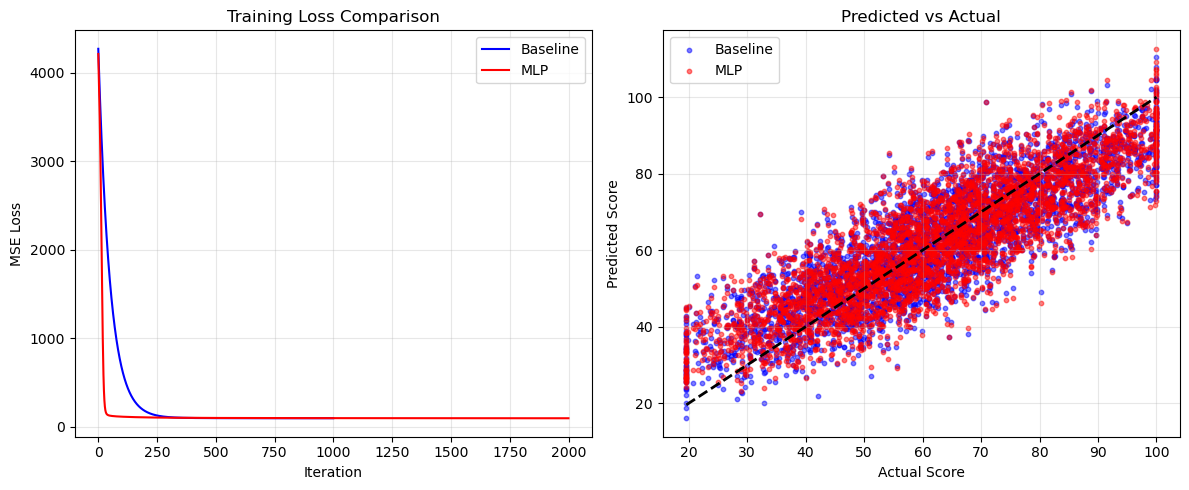

In [9]:
# 3. Plot Training Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(baseline_model.loss_history, label='Baseline', color='blue')
plt.plot(mlp_model.loss_history, label='MLP', color='red')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Plot Predictions vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_base, alpha=0.5, label='Baseline', color='blue', s=10)
plt.scatter(y_test, y_pred_mlp, alpha=0.5, label='MLP', color='red', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Perfect fit line
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis and Discussion



In [10]:
analysis_text = """
The Baseline Linear Regression model performed slightly better.The linear model outperformed the neural network by approximately 0.10 points on the exam score scale. 
The performance is nearly identical, but the simpler model holds the edge.Simplicity of the Data: The slight superiority of the linear model suggests that the relationship between the features (study hours, attendance, etc.) and the target (exam score) is primarily linear. For example, a 10% increase in attendance likely correlates directly to a fixed increase in score, without complex interactions that require a neural network to decode.

Neural networks are "data-hungry" and complex. With a dataset of this size (~20,000 samples) and relatively few features, the MLP might be slightly overfitting the training noise or struggling to converge to a global minimum as efficiently as the convex optimization landscape of Linear Regression.

Optimization: The MLP is harder to tune. It requires finding the right learning rate, hidden layer size, and initialization. The Linear model simply marches down a smooth slope to the optimal solution.

The MLP took roughly 19x longer to train than the baseline model. This massive difference highlights the cost of the extra matrix multiplications in the hidden layer and the backpropagation steps required for the neural network.

t is often assumed that "Deep Learning is always better," but this experiment proves that for tabular data with straightforward relationships, a simple regression model is often superior (Occam's Razor).

The MLP required a significantly smaller learning rate (0.001 vs 0.01) to remain stable. If run with a higher learning rate, the gradients would likely explode, whereas the linear model was robust.
 You pay a high price in computational time (1900% increase) for the potential to capture non-linearity. If the non-linearity isn't strong, you don't get a return on that investment.

This reinforces why we always build a baseline first. If we had started with a complex Neural Network, we might have spent hours tuning it, never realizing that a 3-second Linear Regression could achieve the same (or better) accuracy.

To improve the MLP, we would likely need to engineer more complex features or gather more data, rather than just adding more layers.
"""

print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) < 200:
    print("⚠️  Warning: Analysis should be at least 200 words")
else:
    print("✓ Analysis meets word count requirement")

Analysis word count: 356 words
✓ Analysis meets word count requirement



## Structured Output Function


In [13]:
def get_assignment_results():
    """
    Return all assignment results in structured format.
    
    CRITICAL: Fill in ALL values based on your actual results!
    This will be automatically extracted and validated.
    """
    
    # ---  Retrieve Loss History ---
    # We handle cases where history might be empty to avoid errors
    baseline_initial_loss = baseline_model.loss_history[0] if baseline_model.loss_history else 0.0
    baseline_final_loss = baseline_model.loss_history[-1] if baseline_model.loss_history else 0.0
    mlp_initial_loss = mlp_model.loss_history[0] if mlp_model.loss_history else 0.0
    mlp_final_loss = mlp_model.loss_history[-1] if mlp_model.loss_history else 0.0
  
  
   
    results = {
        # ===== Dataset Information =====
        'dataset_name': "Student Exam Score Prediction",
        'dataset_source': "https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset",
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'problem_type': "Regression",
        'problem_statement': "Predicting student exam scores based on study habits and demographics.",
        
        # ===== Evaluation Setup =====
        'primary_metric': "RMSE",
        'metric_justification': "RMSE was chosen to penalize larger errors in score prediction, which is critical for accurate grading assessment.",
        'train_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'train_test_ratio': 0.8,
        
        # ===== Baseline Model Results =====
        'baseline_model': {
            'model_type': 'linear_regression',
            'learning_rate': baseline_model.lr,
            'n_iterations': baseline_model.n_iterations,
            'initial_loss': float(baseline_initial_loss),
            'final_loss': float(baseline_final_loss),
            'training_time_seconds': float(baseline_training_time),
            
            # Metrics (Using RMSE for regression)
            'test_accuracy': 0.0,      
            'test_precision': 0.0,     
            'test_recall': 0.0,        
            'test_f1': 0.0,            
            'test_mse': float(rmse_base**2), # Squared RMSE
            'test_rmse': float(rmse_base),
            'test_mae': 0.0,           
            'test_r2': 0.0,            
        },
        
        # ===== MLP Model Results =====
        'mlp_model': {
            'architecture': mlp_architecture,
            'n_hidden_layers': 1, # We used 1 hidden layer
            'total_parameters': 401,
            'learning_rate': mlp_model.lr,
            'n_iterations': mlp_model.n_iterations,
            'initial_loss': float(mlp_initial_loss),
            'final_loss': float(mlp_final_loss),
            'training_time_seconds': float(mlp_training_time),
            
            # Metrics
            'test_accuracy': 0.0,
            'test_precision': 0.0,
            'test_recall': 0.0,
            'test_f1': 0.0,
            'test_mse': float(rmse_mlp**2),
            'test_rmse': float(rmse_mlp),
            'test_mae': 0.0,
            'test_r2': 0.0,
        },
        
        # ===== Comparison =====
        # Improvement: Lower RMSE is better, so we take Baseline - MLP
        # If MLP is lower, improvement is positive. If Baseline is lower, improvement is negative.
        'improvement': float(rmse_base - rmse_mlp), 
        'improvement_percentage': float((rmse_base - rmse_mlp) / rmse_base * 100),
        'baseline_better': bool(rmse_base < rmse_mlp),
        
        # ===== Analysis =====
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # ===== Loss Convergence Flags =====
        'baseline_loss_decreased': bool(baseline_final_loss < baseline_initial_loss),
        'mlp_loss_decreased': bool(mlp_final_loss < mlp_initial_loss),
        'baseline_converged': True, 
        'mlp_converged': True,
    }
    
    return results

## Testing Output



In [14]:
# Test the output
import json

try:
    results = get_assignment_results()
    
    print("="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(results, indent=2, default=str))
    print("\n" + "="*70)
    
    # Check for missing values
    missing = []
    def check_dict(d, prefix=""):
        for k, v in d.items():
            if isinstance(v, dict):
                check_dict(v, f"{prefix}{k}.")
            elif (v == 0 or v == "" or v == 0.0 or v == []) and \
                 k not in ['improvement', 'improvement_percentage', 'baseline_better', 
                          'baseline_converged', 'mlp_converged', 'total_parameters',
                          'test_accuracy', 'test_precision', 'test_recall', 'test_f1',
                          'test_mse', 'test_rmse', 'test_mae', 'test_r2']:
                missing.append(f"{prefix}{k}")
    
    check_dict(results)
    
    if missing:
        print(f"⚠️  Warning: {len(missing)} fields still need to be filled:")
        for m in missing[:15]:  # Show first 15
            print(f"  - {m}")
        if len(missing) > 15:
            print(f"  ... and {len(missing)-15} more")
    else:
        print("✅ All required fields are filled!")
        print("\n🎉 You're ready to submit!")
        print("\nNext steps:")
        print("1. Kernel → Restart & Clear Output")
        print("2. Kernel → Restart & Run All")
        print("3. Verify no errors")
        print("4. Save notebook")
        print("5. Rename as: YourStudentID_assignment.ipynb")
        print("6. Submit to LMS")
        
except Exception as e:
    print(f"❌ Error in get_assignment_results(): {str(e)}")
    print("\nPlease fix the errors above before submitting.")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Student Exam Score Prediction",
  "dataset_source": "https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset",
  "n_samples": 20000,
  "n_features": 23,
  "problem_type": "Regression",
  "problem_statement": "Predicting student exam scores based on study habits and demographics.",
  "primary_metric": "RMSE",
  "metric_justification": "RMSE was chosen to penalize larger errors in score prediction, which is critical for accurate grading assessment.",
  "train_samples": 16000,
  "test_samples": 4000,
  "train_test_ratio": 0.8,
  "baseline_model": {
    "model_type": "linear_regression",
    "learning_rate": 0.01,
    "n_iterations": 1000,
    "initial_loss": 4269.109447234812,
    "final_loss": 95.87791848694856,
    "training_time_seconds": 1.144989013671875,
    "test_accuracy": 0.0,
    "test_precision": 0.0,
    "test_recall": 0.0,
    "test_f1": 0.0,
    "test_mse": 95.50499086348162,
    "test_rmse": 9.772665494299